### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [10]:
!nvidia-smi

Mon Feb 10 05:59:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [39]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [12]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.2/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [13]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

# !pip install roboflow

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3bn9JePuo9bqQmI5ZdGt")
project = rf.workspace("depprjct").project("tooth-prjct")
version = project.version(2)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tooth-Prjct-2 in yolov11:: 100%|██████████| 100/100 [00:00<00:00, 7724.89it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [40]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [41]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=250 imgsz=640 plots=True

/content
Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Tooth-Prjct-2/data.yaml, epochs=250, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [43]:
!ls {HOME}/runs/detect/train5/

args.yaml					    P_curve.png       train_batch2.jpg
confusion_matrix_normalized.png			    PR_curve.png      train_batch480.jpg
confusion_matrix.png				    R_curve.png       train_batch481.jpg
events.out.tfevents.1739167749.5ba3cae10d21.5892.0  results.csv       train_batch482.jpg
F1_curve.png					    results.png       val_batch0_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg  val_batch0_pred.jpg
labels.jpg					    train_batch1.jpg  weights


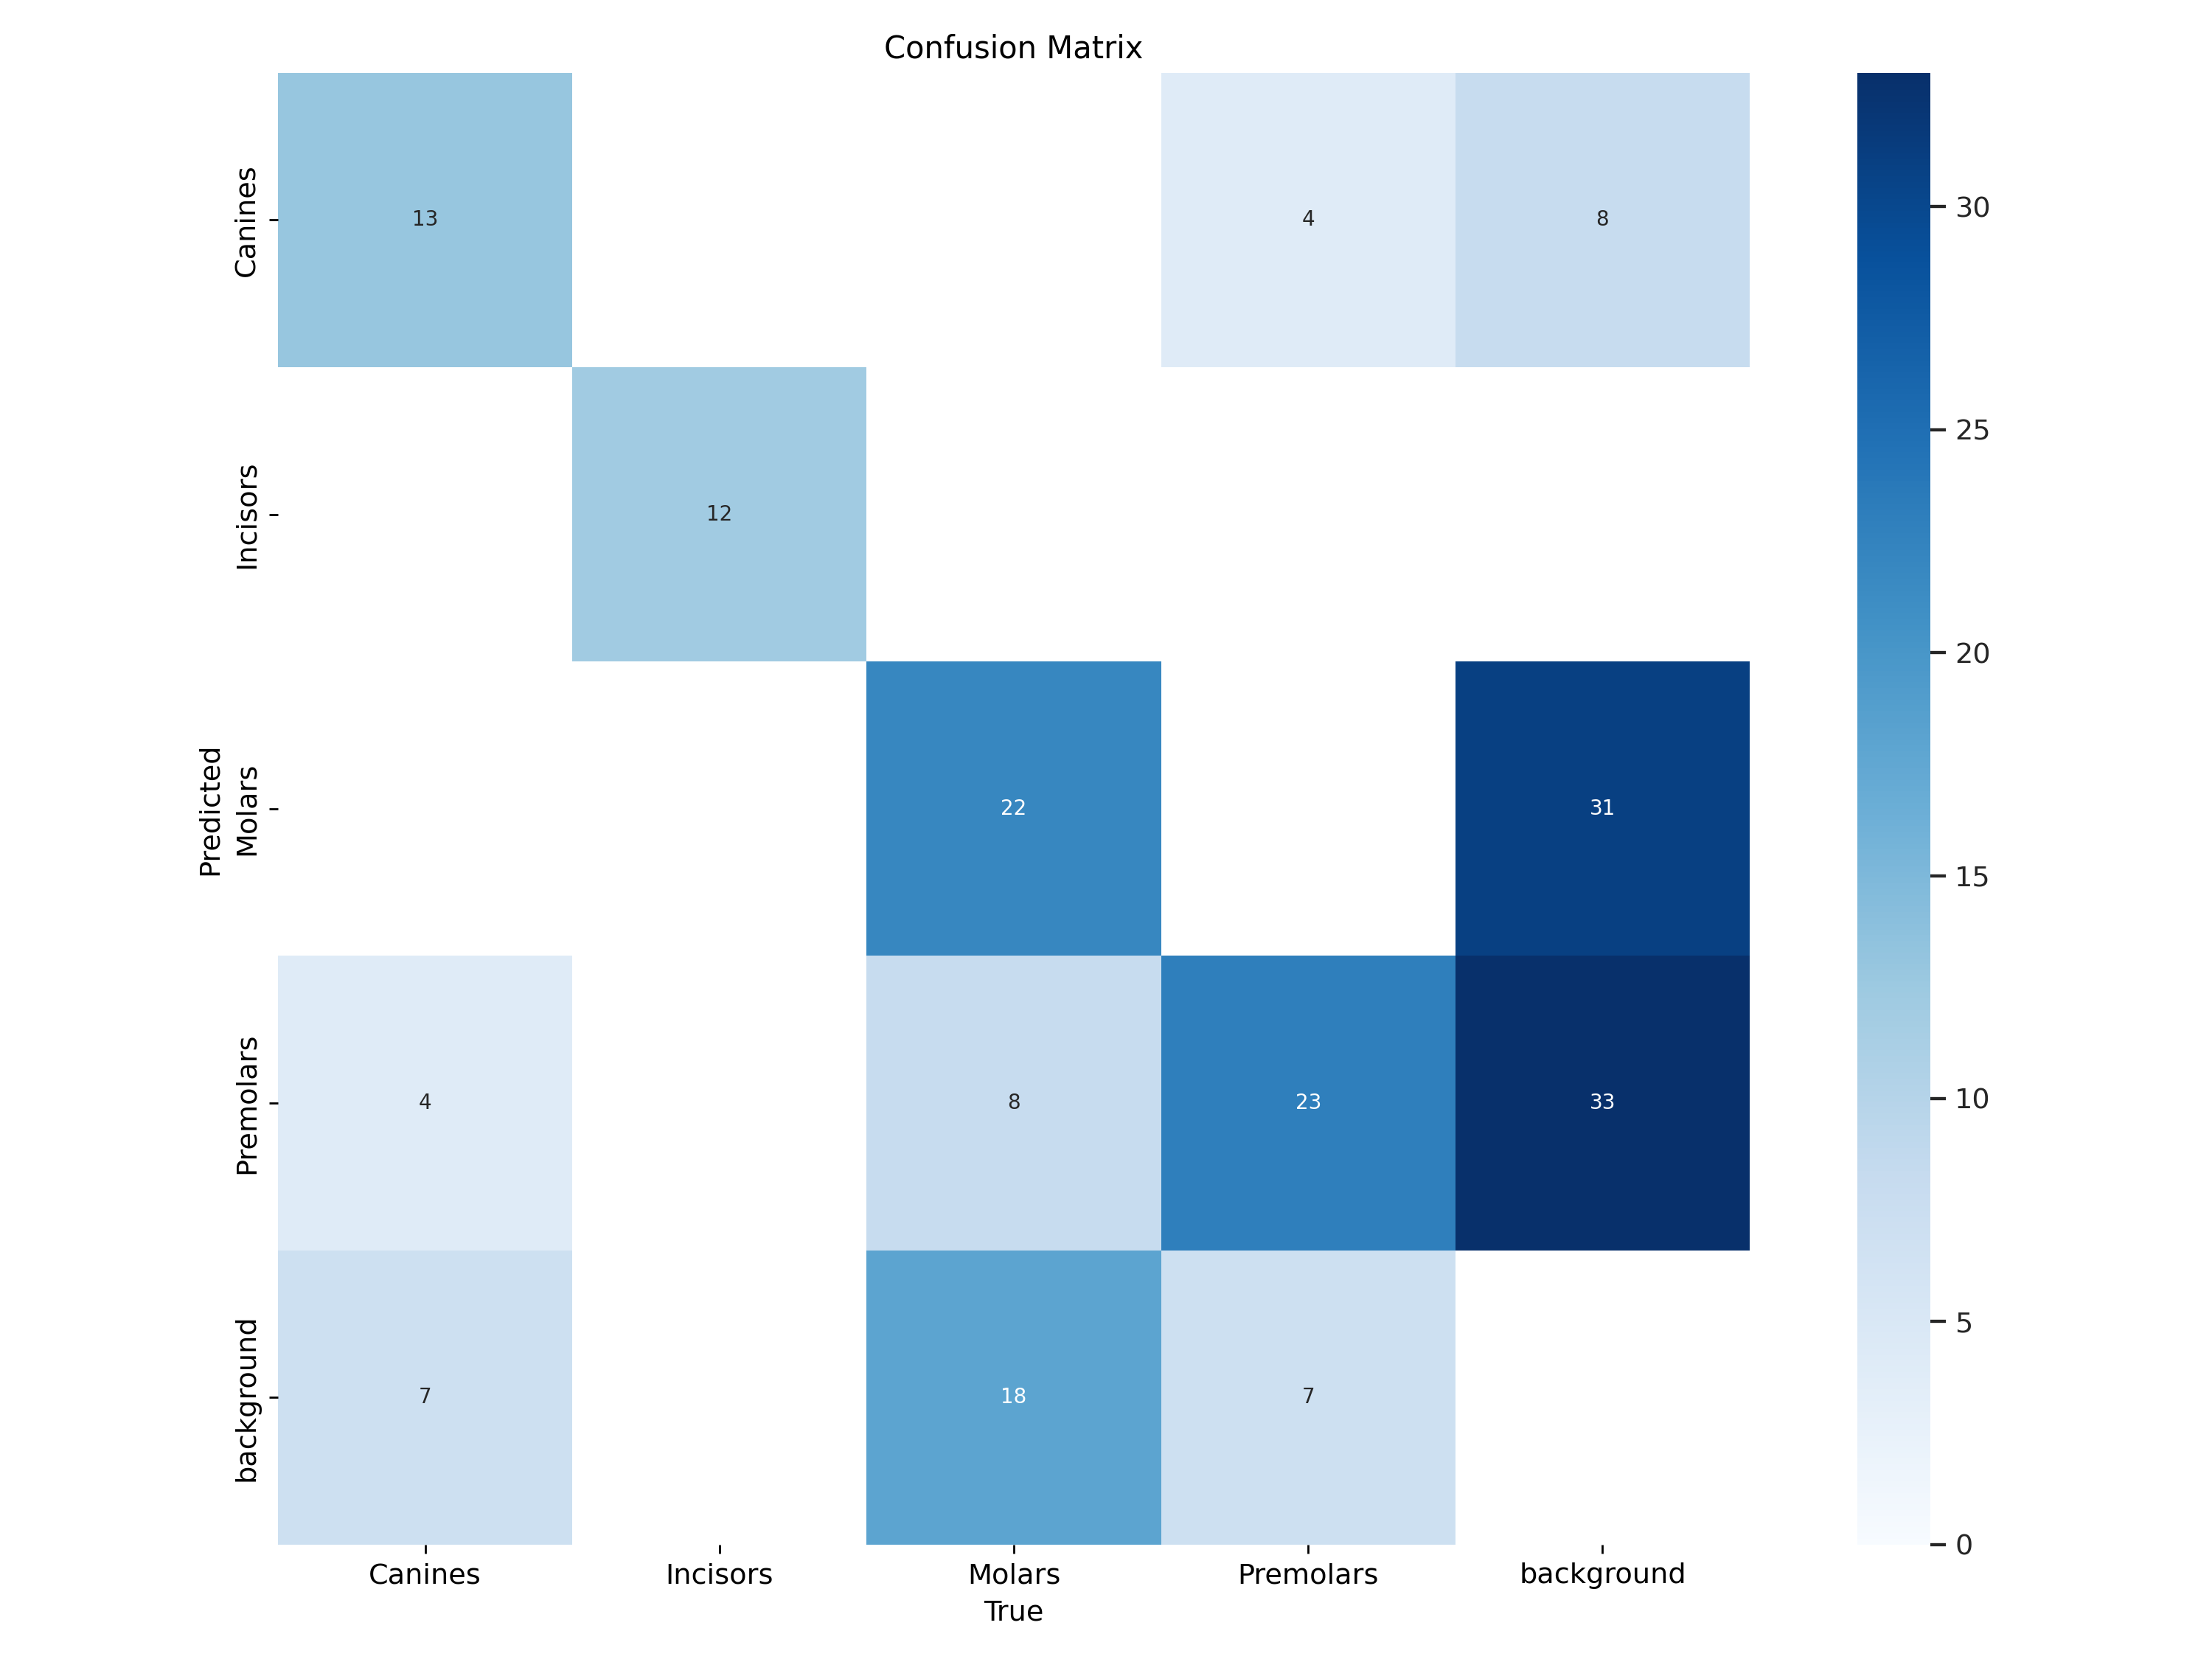

In [44]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=600)

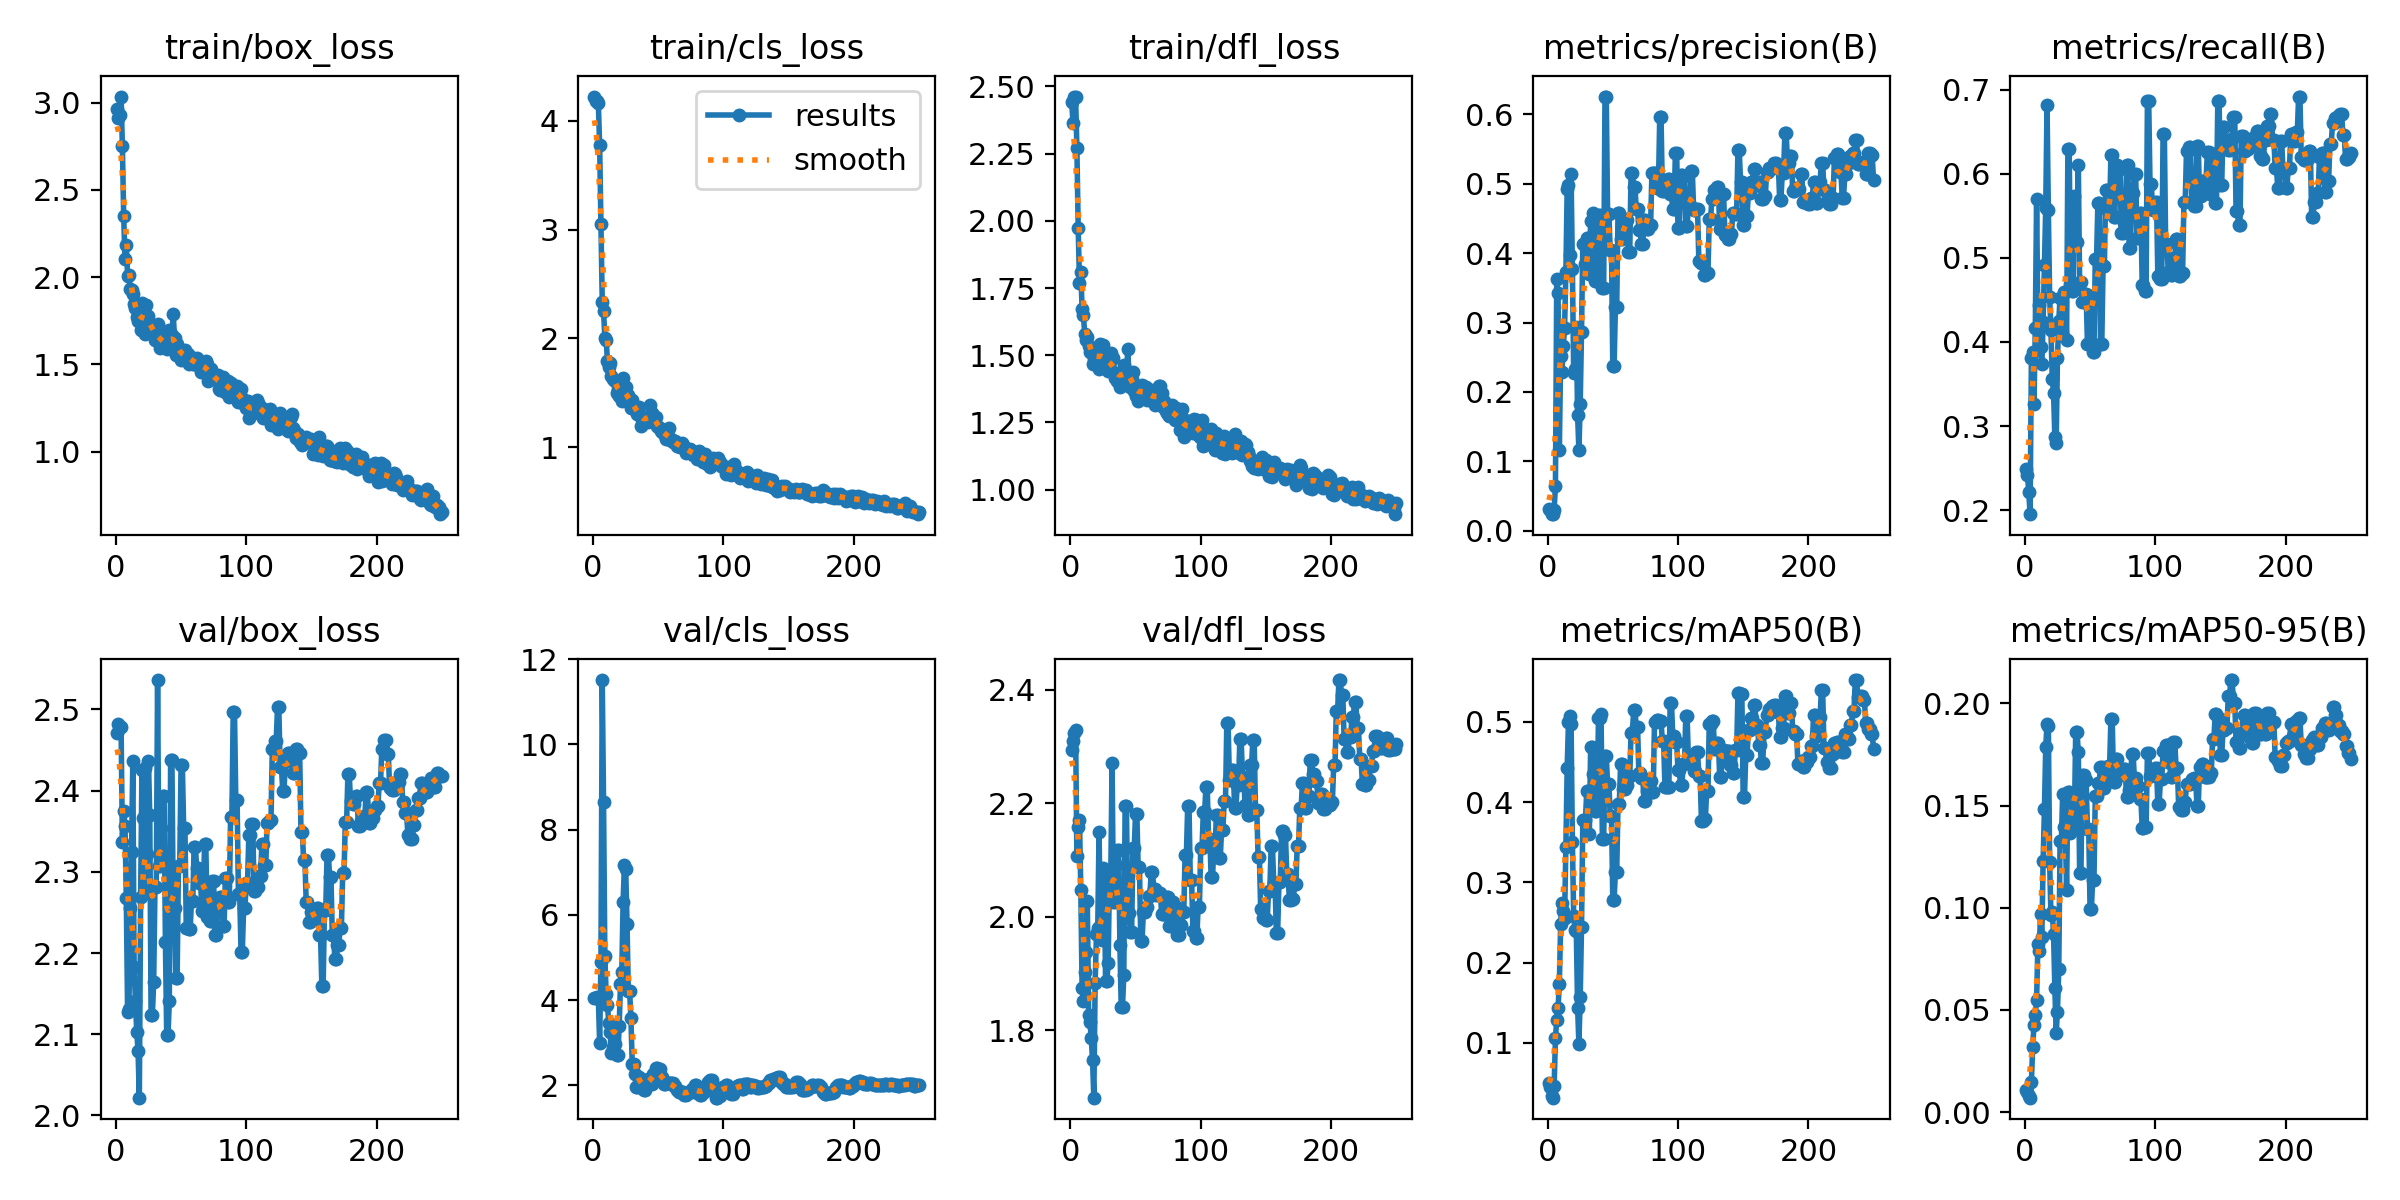

In [45]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train5/results.png', width=600)

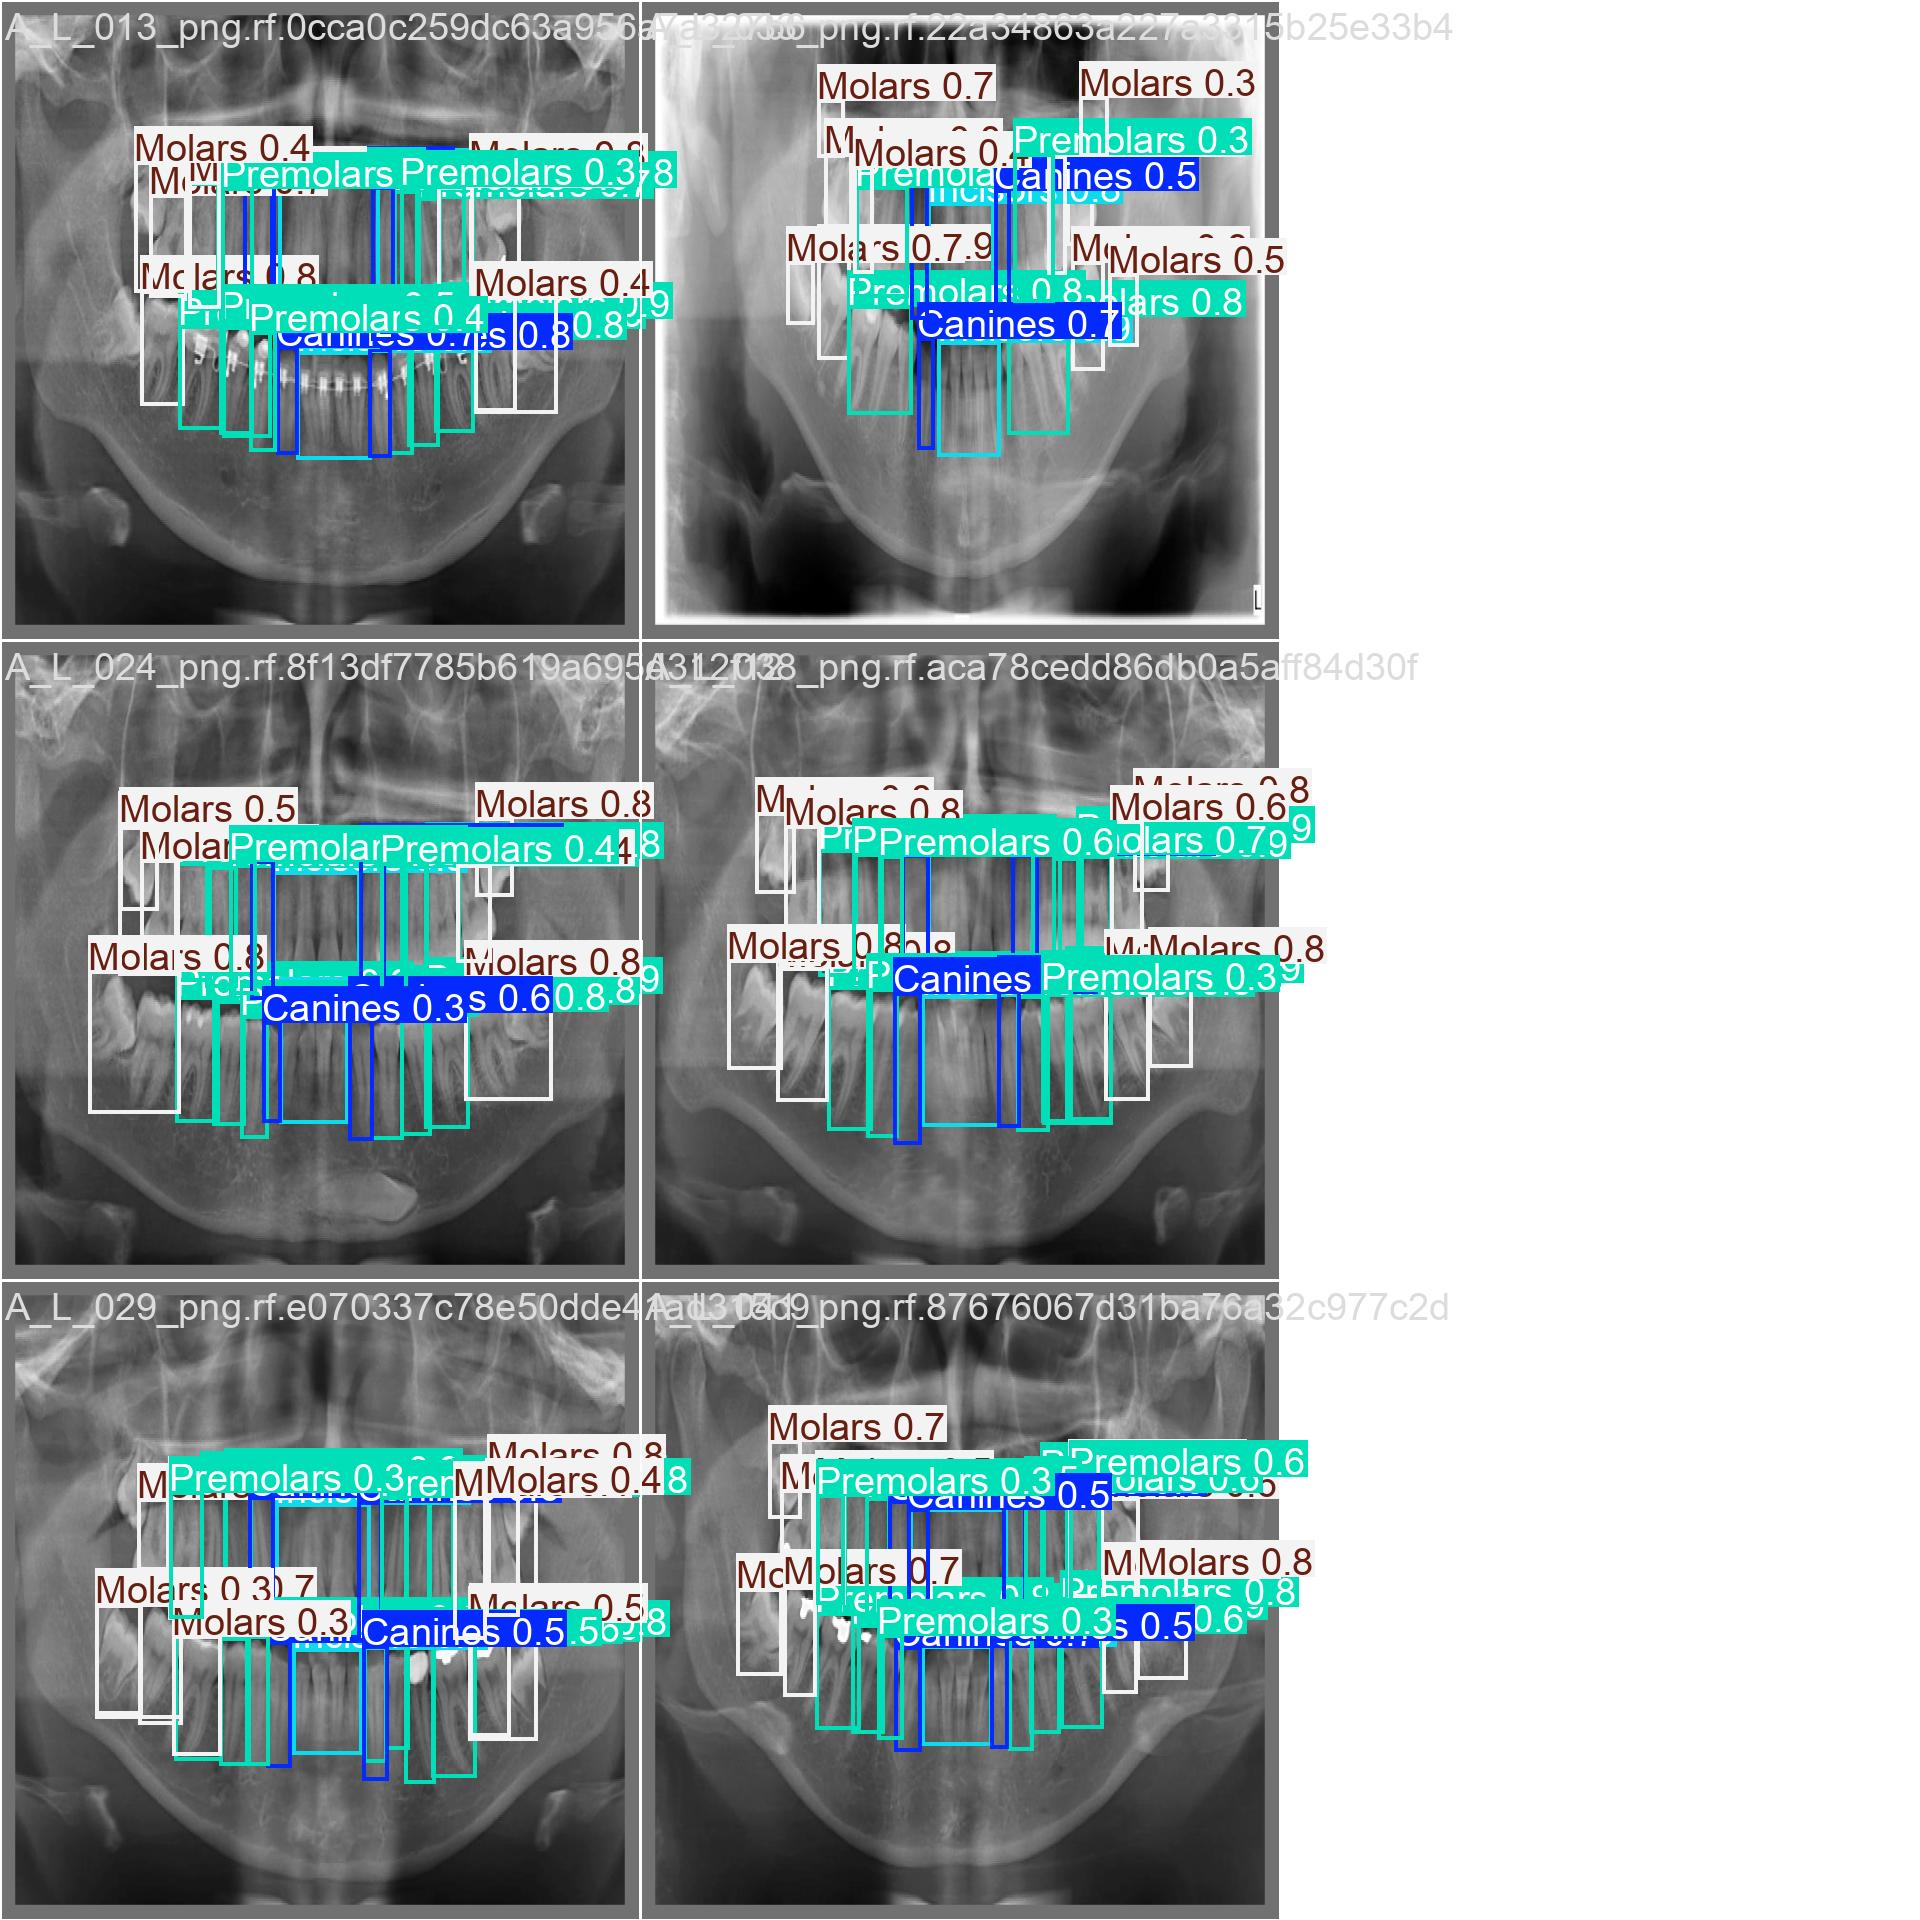

In [46]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train5/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [47]:
!yolo task=detect mode=val model={HOME}/runs/detect/train5/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Tooth-Prjct-2/valid/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100% 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  2.67it/s]
                   all          6        118      0.521      0.645      0.521      0.211
               Canines          6         24      0.579      0.667      0.523      0.164
              Incisors          6         12      0.863      0.917      0.865      0.376
                Molars          6         48       0.36       0.41      0.382      0.173
             Premolars          6         34      0.281      0.588      0.312       0.13
Speed: 0.9ms preprocess, 14.8ms inference, 0.0ms loss, 23.8ms postprocess per image
Results saved to runs/detect/val3
💡 Learn more at h

## Inference with custom model

In [48]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train5/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/6 /content/datasets/Tooth-Prjct-2/test/images/A_L_008_png.rf.02b49746de4831a94e8cd3c21afd108e.jpg: 640x640 4 Caniness, 2 Incisorss, 9 Molarss, 12 Premolarss, 16.7ms
image 2/6 /content/datasets/Tooth-Prjct-2/test/images/A_L_009_png.rf.4aefa84e221b0e78f961c0287130f020.jpg: 640x640 4 Caniness, 2 Incisorss, 9 Molarss, 13 Premolarss, 16.2ms
image 3/6 /content/datasets/Tooth-Prjct-2/test/images/A_L_015_png.rf.97a5119887ade2eaff263751c2f54e49.jpg: 640x640 6 Caniness, 2 Incisorss, 10 Molarss, 12 Premolarss, 15.6ms
image 4/6 /content/datasets/Tooth-Prjct-2/test/images/A_L_026_png.rf.5f29724e2c90de361ce067d5f5e45ea6.jpg: 640x640 7 Caniness, 2 Incisorss, 11 Molarss, 12 Premolarss, 15.6ms
image 5/6 /content/datasets/Tooth-Prjct-2/test/images/A_L_039_png.rf.a89c4afd89ae8ed1e2ab711496cda875.jpg: 640x640 5 Caniness, 2 Incisorss,

**NOTE:** Let's take a look at few results.

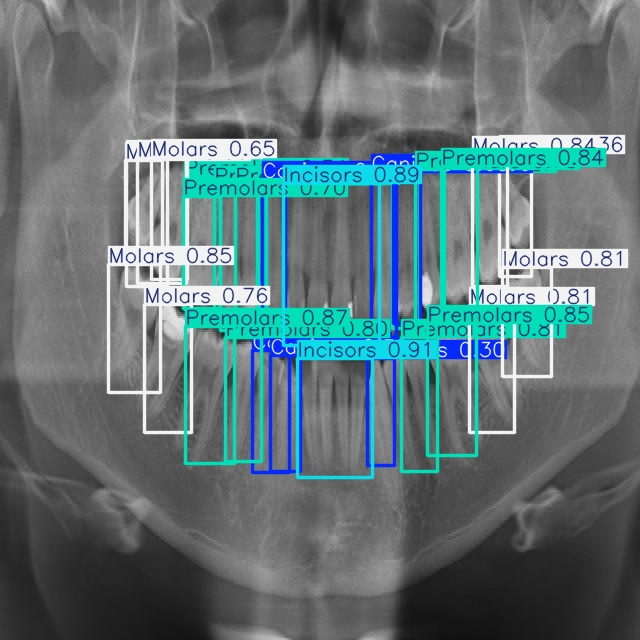

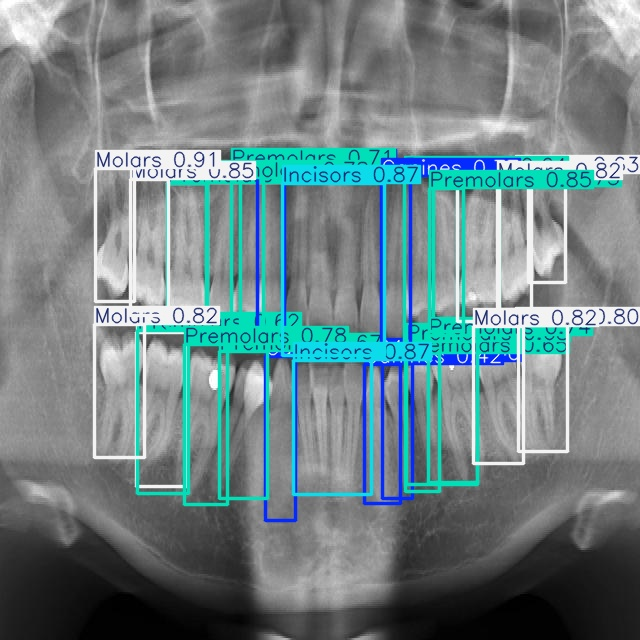

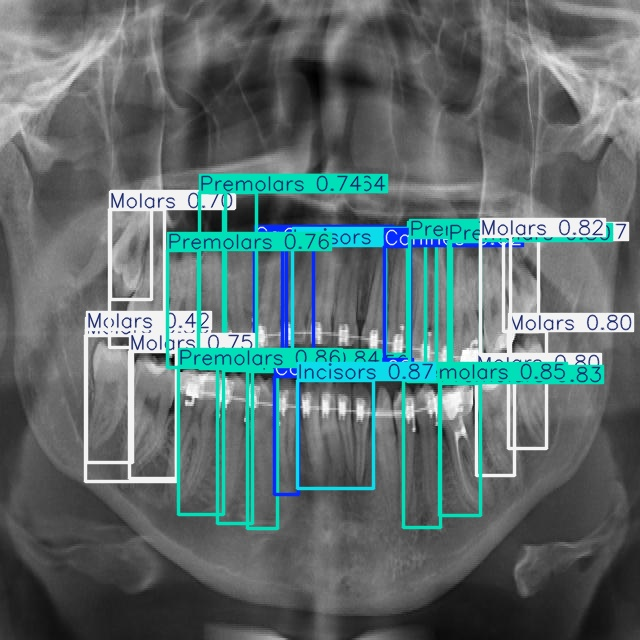

In [49]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")